# Libraries

In [14]:
import numpy as np
import pandas as pd

# metrics

In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import VarianceThreshold 
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    silhouette_score,
    davies_bouldin_score
)

# class MyPCA

In [60]:
class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None 
        self.explained_variance_ratio_ = None 
        self.cumulative_explained_variance_ = None 
        self.n_components_auto_ = None
        self.noise_variance_ = None

    def fit(self, X):
        # Center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        n_samples, n_features = X.shape
        
        if n_samples >= n_features:
            U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
            self.components_ = Vt
            explained_variance = (S ** 2) / (n_samples - 1)
        else:
            C = (X_centered.T @ X_centered) / (n_samples - 1)
            eigenvalues, eigenvectors = np.linalg.eigh(C)
            
            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            
            pos_mask = eigenvalues > 1e-12
            self.components_ = eigenvectors[:, pos_mask].T
            explained_variance = eigenvalues[pos_mask]
        
        self.explained_variance_ = explained_variance
        
        total_var = np.sum(explained_variance)
        if total_var > 0:
            self.explained_variance_ratio_ = explained_variance / total_var
        else:
            self.explained_variance_ratio_ = np.zeros_like(explained_variance)
        
        self.cumulative_explained_variance_ = np.cumsum(self.explained_variance_ratio_)
        
        if self.n_components is not None and isinstance(self.n_components, int):
            if self.n_components < len(explained_variance):
                self.noise_variance_ = np.mean(explained_variance[self.n_components:])
            else:
                self.noise_variance_ = 0.0
        
        if self.n_components is not None:
            if isinstance(self.n_components, int):
                n_components = min(self.n_components, len(self.explained_variance_ratio_))
                self.components_ = self.components_[:n_components]
                self.explained_variance_ = self.explained_variance_[:n_components]
                self.explained_variance_ratio_ = self.explained_variance_ratio_[:n_components]
                self.cumulative_explained_variance_ = self.cumulative_explained_variance_[:n_components]
                self.n_components_auto_ = n_components
            elif isinstance(self.n_components, float) and 0 < self.n_components < 1:
                n_components = np.argmax(self.cumulative_explained_variance_ >= self.n_components) + 1
                self.components_ = self.components_[:n_components]
                self.explained_variance_ = self.explained_variance_[:n_components]
                self.explained_variance_ratio_ = self.explained_variance_ratio_[:n_components]
                self.cumulative_explained_variance_ = self.cumulative_explained_variance_[:n_components]
                self.n_components_auto_ = n_components
            else:
                self.n_components_auto_ = len(self.explained_variance_ratio_)
        else:
            explained_variance_diff = np.diff(self.explained_variance_ratio_)
            if len(explained_variance_diff) > 0:
                elbow_idx = np.argmax(explained_variance_diff < np.mean(explained_variance_diff[:5]) * 0.1)
                if elbow_idx > 0:
                    n_components = elbow_idx + 1
                else:
                    n_components = np.argmax(self.cumulative_explained_variance_ >= 0.95) + 1
                
                n_components = max(n_components, 2)  
                self.components_ = self.components_[:n_components]
                self.explained_variance_ = self.explained_variance_[:n_components]
                self.explained_variance_ratio_ = self.explained_variance_ratio_[:n_components]
                self.cumulative_explained_variance_ = self.cumulative_explained_variance_[:n_components]
                self.n_components_auto_ = n_components
        
        return self

    def transform(self, X):
        if self.mean_ is None or self.components_ is None:
            raise ValueError("Mô hình PCA chưa được huấn luyện.")
        X_centered = X - self.mean_
        return X_centered @ self.components_.T

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# KMeans

In [61]:
def kmeans(X, k=2, max_iters=300, tol=1e-8, n_init=20, init_method='kmeans++', random_state=None, early_stopping_iter=10):
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed=random_state)

    best_inertia = float('inf')
    best_labels = None
    best_centers = None
    best_n_iter = 0

    for init_attempt in range(n_init):
        # Enhanced initialization with better seeding
        if init_method == 'kmeans++':
            centers = np.zeros((k, n_features))
            # First center is chosen randomly
            idx = rng.choice(n_samples)
            centers[0] = X[idx].copy()

            # Choose remaining centers with probability proportional to distance squared
            for i in range(1, k):
                # Vectorized distance calculation with improved numeric stability
                dist_sq = np.min(np.sum((X[:, np.newaxis, :] - centers[None, :i, :]) ** 2, axis=2), axis=1)
                dist_sq = np.maximum(dist_sq, 1e-10)  # Avoid numerical instability

                # Normalize to create probability distribution
                probs = dist_sq / np.sum(dist_sq)
                idx = rng.choice(n_samples, p=probs)
                centers[i] = X[idx].copy()
        else:
            # Random initialization
            indices = rng.choice(n_samples, size=k, replace=False)
            centers = X[indices].copy()

        # Optimization loop with improved early stopping
        labels = np.zeros(n_samples, dtype=int)
        prev_inertias = []
        distances = np.zeros((n_samples, k))

        for iteration in range(max_iters):
            # Optimized distance calculation with broadcasting
            for i in range(k):
                distances[:, i] = np.sum((X - centers[i])**2, axis=1)

            new_labels = np.argmin(distances, axis=1)

            # Handle empty clusters with smart reassignment strategy
            for i in range(k):
                if np.sum(new_labels == i) == 0:
                    # Find the points closest to the old center of this empty cluster
                    closest_points_idx = np.argsort(np.sum((X - centers[i])**2, axis=1))[:5]
                    # Reassign one of these points to the empty cluster
                    new_labels[closest_points_idx[0]] = i

            # Update centers - vectorized with fallback strategy
            new_centers = np.array([np.mean(X[new_labels == i], axis=0) if np.sum(new_labels == i) > 0
                                   else centers[i] for i in range(k)])

            # Calculate inertia more efficiently
            inertia = 0
            for i in range(k):
                mask = new_labels == i
                if np.any(mask):
                    diff = X[mask] - new_centers[i]
                    inertia += np.sum(diff * diff)

            # Enhanced early stopping check
            prev_inertias.append(inertia)
            if len(prev_inertias) > early_stopping_iter:
                recent_improvements = np.diff(prev_inertias[-early_stopping_iter:])
                recent_rel_improvements = np.abs(recent_improvements) / (np.abs(prev_inertias[-early_stopping_iter-1]) + 1e-10)
                if np.all(recent_rel_improvements < tol):
                    break

            # Check for convergence
            center_shift = np.sum((new_centers - centers)**2)
            rel_center_shift = center_shift / (np.sum(centers**2) + 1e-10)
            centers = new_centers

            if np.all(labels == new_labels) or rel_center_shift < tol:
                break

            labels = new_labels

        # Keep best result
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centers = centers.copy()
            best_n_iter = iteration + 1

    return best_labels, best_centers, best_inertia, best_n_iter

# preprocess

In [72]:
def preprocessing(X):
    X_processed = X.copy().astype(float)

    # Standardize the data
    scaler = StandardScaler()
    X_processed = scaler.fit_transform(X_processed)

    # Handle Inf values
    X_processed[np.isinf(X_processed)] = np.nan

    # Identify columns with many NaN values
    nan_ratio = np.isnan(X_processed).mean(axis=0)
    high_nan_cols = nan_ratio > 0.3
    
    # For columns with high NaN ratio, use mean imputation
    # For others, use median imputation (more robust)
    if np.any(high_nan_cols):
        mean_imputer = SimpleImputer(strategy='mean')
        X_processed[:, high_nan_cols] = mean_imputer.fit_transform(X_processed[:, high_nan_cols])
    
    # For remaining columns, use median imputation
    median_imputer = SimpleImputer(strategy='median')
    X_processed = median_imputer.fit_transform(X_processed)
    
    # Adaptive outlier handling based on column distribution
    for col_idx in range(X_processed.shape[1]):
        col_data = X_processed[:, col_idx]
        
        # Check if column has enough variance to process
        if np.std(col_data) < 1e-6:
            continue
            
        # Calculate skewness more accurately
        mean_val = np.mean(col_data)
        std_val = np.std(col_data)
        skewness = np.mean(((col_data - mean_val) / std_val)**3)
        
        # Calculate percentiles for outlier detection
        Q1 = np.percentile(col_data, 25)
        Q3 = np.percentile(col_data, 75)
        IQR = Q3 - Q1
        
        # Adaptive factors based on skewness and distribution
        lower_factor = 2.0
        upper_factor = 2.0
        
        # Adjust factors based on skewness
        if skewness > 1.5:  # Highly right-skewed
            upper_factor = 3.0
            lower_factor = 1.5
        elif skewness < -1.5:  # Highly left-skewed
            lower_factor = 3.0
            upper_factor = 1.5
        elif skewness > 0.5:  # Moderately right-skewed
            upper_factor = 2.5
            lower_factor = 1.5
        elif skewness < -0.5:  # Moderately left-skewed
            lower_factor = 2.5
            upper_factor = 1.5
            
        # Calculate bounds
        lower_bound = Q1 - lower_factor * IQR
        upper_bound = Q3 + upper_factor * IQR
        
        # Clip outliers
        X_processed[:, col_idx] = np.clip(X_processed[:, col_idx], lower_bound, upper_bound)

    # Use RobustScaler for scaling (more resilient to outliers)
    scaler = RobustScaler(quantile_range=(10, 90))  # Using 10-90 percentile for scaling
    X_scaled = scaler.fit_transform(X_processed)
    
    # Final check for any remaining NaN/Inf values
    X_scaled[np.isnan(X_scaled)] = 0
    X_scaled[np.isinf(X_scaled)] = 0

    return X_scaled

# feature selection

In [73]:
def feature_selection(X, variance_threshold_quantile=0.03, correlation_threshold=0.85, mutual_info_threshold=0.02):
    n_features_original = X.shape[1]
    n_samples = X.shape[0]
    
    # Step 1: Remove low variance features
    variances = np.var(X, axis=0)
    var_thresh_val = np.quantile(variances, variance_threshold_quantile)
    var_thresh_val = max(var_thresh_val, 1e-8)  # Ensure minimum threshold
    
    selector_var = VarianceThreshold(threshold=var_thresh_val)
    try:
        X_after_variance = selector_var.fit_transform(X)
        mask_variance = selector_var.get_support()
    except ValueError:
        mask_variance = np.ones(n_features_original, dtype=bool)
        X_after_variance = X.copy()
    
    # Ensure at least some features are kept
    if X_after_variance.shape[1] == 0:
        top_var_indices = np.argsort(variances)[-min(5, n_features_original):]
        mask_variance = np.zeros(n_features_original, dtype=bool)
        mask_variance[top_var_indices] = True
        X_after_variance = X[:, mask_variance]
    
    # Step 2: Advanced correlation analysis
    # Use pandas for more sophisticated correlation handling
    df_temp = pd.DataFrame(X_after_variance)
    
    # Calculate correlation matrix
    try:
        corr_matrix = df_temp.corr(method='spearman').abs()  # Use spearman for better handling of non-linear relationships
    except:
        corr_matrix = df_temp.corr().abs()  # Fallback to pearson
    
    # Get upper triangle of correlation matrix
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Sort pairs by correlation strength
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if upper_triangle[i, j] and corr_matrix.iloc[i, j] > correlation_threshold:
                high_corr_pairs.append((i, j, corr_matrix.iloc[i, j]))
    
    # Sort pairs by correlation strength (highest first)
    high_corr_pairs.sort(key=lambda x: x[2], reverse=True)
    
    # Intelligently remove features
    to_drop = set()
    for i, j, corr_val in high_corr_pairs:
        # Skip if either feature is already marked for removal
        if i in to_drop or j in to_drop:
            continue
        
        # Keep feature with higher variance or more information content
        i_variance = np.var(df_temp.iloc[:, i])
        j_variance = np.var(df_temp.iloc[:, j])
        
        # Also consider correlation with other features
        i_mean_corr = corr_matrix.iloc[i, :].mean()
        j_mean_corr = corr_matrix.iloc[j, :].mean()
        
        # Weighted decision: 0.7*variance + 0.3*(1-mean_correlation)
        i_score = 0.7 * i_variance - 0.3 * i_mean_corr
        j_score = 0.7 * j_variance - 0.3 * j_mean_corr
        
        if i_score < j_score:
            to_drop.add(i)
        else:
            to_drop.add(j)
    
    # Get columns to keep
    to_keep = [col for col in range(df_temp.shape[1]) if col not in to_drop]
    X_selected_df = df_temp.iloc[:, to_keep]
    X_selected = X_selected_df.values
    
    # Create final feature mask
    original_indices_after_variance = np.where(mask_variance)[0]
    
    # Handle edge case where all features might be dropped
    if len(to_keep) == 0 and len(original_indices_after_variance) > 0:
        # Keep at least the top 3 variance features
        top_variance_idx = np.argsort(np.var(X_after_variance, axis=0))[-min(3, len(original_indices_after_variance)):]
        to_keep = top_variance_idx.tolist()
        X_selected = X_after_variance[:, to_keep]
    
    # Map indices back to original feature space
    if len(to_keep) > 0:
        final_kept_original_indices = original_indices_after_variance[to_keep]
    else:
        final_kept_original_indices = []
    
    feature_mask_final = np.zeros(n_features_original, dtype=bool)
    if len(final_kept_original_indices) > 0:
        feature_mask_final[final_kept_original_indices] = True
    elif n_features_original > 0:
        # Keep top features as fallback
        top_indices = np.argsort(variances)[-min(5, n_features_original):]
        feature_mask_final[top_indices] = True
        X_selected = X[:, feature_mask_final]
    
    return X_selected, feature_mask_final

# visualize functions

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualization(X_pca, labels, true_labels=None, title="PCA Visualization", centers_pca=None):
    rng = np.random.RandomState(42)

    n_components_pca = X_pca.shape[1]
    
    num_plots = 1
    if true_labels is not None:
        num_plots = 2
        
    fig = plt.figure(figsize=(7 * num_plots, 6))
    fig.suptitle(title, fontsize=16)

    # Plot clustering results
    ax1_idx = 1
    if n_components_pca >= 3:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx, projection='3d')
        scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        if centers_pca is not None and centers_pca.shape[1] >=3 :
            ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2], s=200, c='red', marker='X', label='Centers')
    elif n_components_pca == 2:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx)
        scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        if centers_pca is not None and centers_pca.shape[1] >=2:
            ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='red', marker='X', label='Centers')
    else: 
        ax1 = fig.add_subplot(1, num_plots, ax1_idx)
        ax1.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]) + rng.uniform(-0.1, 0.1, size=X_pca.shape[0]), 
                    c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_yticks([]) 
        if centers_pca is not None and centers_pca.shape[1] >=1:
            ax1.scatter(centers_pca[:, 0], np.zeros_like(centers_pca[:,0]), s=200, c='red', marker='X', label='Centers')

    ax1.set_title("Clustering Results")
    if centers_pca is not None: ax1.legend()


    # Plot true labels if available
    if true_labels is not None:
        ax2_idx = 2
        if n_components_pca >= 3:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx, projection='3d')
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_ylabel('PC2')
            ax2.set_zlabel('PC3')
        elif n_components_pca == 2:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx)
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_ylabel('PC2')
        else: 
            ax2 = fig.add_subplot(1, num_plots, ax2_idx)
            ax2.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]) + rng.uniform(-0.1, 0.1, size=X_pca.shape[0]),
                        c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_yticks([])
        ax2.set_title("True Labels")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# hàm đánh giá phân cụm

In [75]:
def evaluate_clustering(X_data_for_internal_metrics, labels, true_labels=None):
    metrics_dict = {}
    y_pred_matched = labels.copy() 

    unique_labels_pred = np.unique(labels)
    n_clusters_pred = len(unique_labels_pred)

    # 1. Internal Metrics
    if n_clusters_pred >= 2 and n_clusters_pred < X_data_for_internal_metrics.shape[0]:
        metrics_dict['silhouette'] = silhouette_score(X_data_for_internal_metrics, labels)
        metrics_dict['davies_bouldin'] = davies_bouldin_score(X_data_for_internal_metrics, labels)
    else:
        metrics_dict['silhouette'] = -1 
        metrics_dict['davies_bouldin'] = -1 

    # 2. External Metrics
    if true_labels is not None:
        y_true_numeric = np.asarray(true_labels)
        unique_labels_true = np.unique(y_true_numeric)

        if len(unique_labels_true) == 2 and n_clusters_pred == 2:
            # Logic so khớp nhãn cho trường hợp nhị phân
            # Thử gán unique_labels_pred[0] -> unique_labels_true[0], unique_labels_pred[1] -> unique_labels_true[1]
            y_pred_temp1 = labels.copy()
            map1 = {unique_labels_pred[0]: unique_labels_true[0], unique_labels_pred[1]: unique_labels_true[1]}
            for old, new in map1.items(): y_pred_temp1[labels == old] = new
            acc1 = accuracy_score(y_true_numeric, y_pred_temp1)

            # Thử gán unique_labels_pred[0] -> unique_labels_true[1], unique_labels_pred[1] -> unique_labels_true[0]
            y_pred_temp2 = labels.copy()
            map2 = {unique_labels_pred[0]: unique_labels_true[1], unique_labels_pred[1]: unique_labels_true[0]}
            for old, new in map2.items(): y_pred_temp2[labels == old] = new
            acc2 = accuracy_score(y_true_numeric, y_pred_temp2)

            if acc1 >= acc2:
                y_pred_matched = y_pred_temp1
            else:
                y_pred_matched = y_pred_temp2
            
            metrics_dict['accuracy'] = accuracy_score(y_true_numeric, y_pred_matched)
            metrics_dict['precision'] = precision_score(y_true_numeric, y_pred_matched, zero_division=0)
            metrics_dict['recall'] = recall_score(y_true_numeric, y_pred_matched, zero_division=0)
            metrics_dict['f1'] = f1_score(y_true_numeric, y_pred_matched, zero_division=0)
            metrics_dict['confusion_matrix'] = confusion_matrix(y_true_numeric, y_pred_matched)
        else:
            print("  Warning: External metrics (accuracy, precision, etc.) are best for binary classification with 2 clusters.")
            print("           Current unique true labels:", unique_labels_true, "Current unique predicted clusters:", unique_labels_pred)
            metrics_dict['accuracy'] = -1 
            metrics_dict['precision'] = -1
            metrics_dict['recall'] = -1
            metrics_dict['f1'] = -1
            metrics_dict['confusion_matrix'] = np.array([[-1,-1],[-1,-1]])
            
    return metrics_dict, y_pred_matched

# clustering pipeline

In [76]:
def clustering_pipeline(X, y=None, n_clusters=2, 
                       variance_threshold_quantile=0.03, 
                       correlation_threshold=0.85, 
                       pca_variance_explained_threshold=0.90, 
                       kmeans_max_iters=300, 
                       kmeans_tol=1e-8, 
                       kmeans_n_init=20, 
                       kmeans_init_method='kmeans++', 
                       kmeans_random_state=42,
                       kmeans_early_stopping_iter=10): 
    
    # Step 1: data preprocessing
    print("\nBước 1: Tiền xử lý dữ liệu ...")
    print(f" Kích thước dữ liệu ban đầu: {X.shape}")
    X_preprocessed = preprocessing(X)
    print(f" Kích thước dữ liệu sau tiền xử lý: {X_preprocessed.shape}")
    
    # Step 2: feature selection
    print("\nBước 2: Chọn đặc trưng ...")
    X_selected, feature_mask = feature_selection(
        X_preprocessed, 
        variance_threshold_quantile=variance_threshold_quantile,
        correlation_threshold=correlation_threshold
    )
    print(f" Chọn {X_selected.shape[1]} đặc trưng từ {X_preprocessed.shape[1]} đặc trưng ban đầu")
    
    if X_selected.shape[1] == 0:
        print("Lỗi: Không còn đặc trưng nào sau khi chọn. Sử dụng dữ liệu trước tiền xử lý.")
        X_selected = X_preprocessed
        feature_mask = np.ones(X_preprocessed.shape[1], dtype=bool)
    
    # Step 3: Apply PCA
    print("\nBước 3: Áp dụng PCA ...")
    pca = MyPCA(n_components=pca_variance_explained_threshold)
    X_pca = pca.fit_transform(X_selected)
    n_pca_components = pca.components_.shape[0]
    print(f" Chọn số thành phần PCA là: {n_pca_components}")
    print(f" Với phương sai giải thích: {pca.cumulative_explained_variance_[-1]:.4f}")

    # Step 4: Perform clustering with KMeans
    print("\nBước 4: Phân cụm với KMeans ...")
    predicted_labels, centers_raw, inertia, n_iter = kmeans(
        X_pca, 
        k=n_clusters,
        max_iters=kmeans_max_iters, 
        tol=kmeans_tol,
        n_init=kmeans_n_init, 
        init_method=kmeans_init_method,
        random_state=kmeans_random_state,
        early_stopping_iter=kmeans_early_stopping_iter
    )
    centers_pca = centers_raw
    print(f" KMeans đã chạy {n_iter} lần")
    
    # Step 5: Evaluate results
    print("\nBước 5: Đánh giá kết quả phân cụm ...")
    metrics, matched_labels = evaluate_clustering(X_pca, predicted_labels, y)
    
    if X_pca.shape[0] > n_clusters and n_clusters >= 2:
        if 'silhouette' not in metrics or metrics['silhouette'] == -1:
            try:
                metrics['silhouette'] = silhouette_score(X_pca, predicted_labels)
            except:
                metrics['silhouette'] = -1
        
        if 'davies_bouldin' not in metrics or metrics['davies_bouldin'] == -1:
            try:
                metrics['davies_bouldin'] = davies_bouldin_score(X_pca, predicted_labels)
            except:
                metrics['davies_bouldin'] = -1
        
    # Print final results
    print(" Kết quả:")
    print(f" - Số đặc trưng được chọn: {np.sum(feature_mask)} of {len(feature_mask)}")
    print(f" - Số thành phần PCA: {n_pca_components}")

    for metric, value in metrics.items():
        if metric == 'confusion_matrix':
            if y is not None and isinstance(value, np.ndarray) and value.shape == (2,2) and value[0,0] != -1:
                print(" - Confusion Matrix:")
                print(pd.DataFrame(value, index=['True Normal', 'True Cancer'], columns=['Pred Normal', 'Pred Cancer']))
        elif isinstance(value, (int, float)):
            print(f" - {metric.capitalize()}: {value:.4f}")

    # Step 6: Visualization
    print("\nBước 6: Visualization ...")
    labels_for_viz = matched_labels if y is not None else predicted_labels
    visualization(X_pca, labels_for_viz, y,
                 title=f"Clustering Results with {n_pca_components} PCA Components",
                 centers_pca=centers_pca)
    
    
    # Return comprehensive results
    return {
        'labels': matched_labels if y is not None else predicted_labels,
        'metrics': metrics,
        'n_pca_components': n_pca_components,
        'X_pca': X_pca,
        'feature_mask': feature_mask,
        'pca_model': pca,
        'centers': centers_pca,
    }

# Chuẩn bị dữ liệu

In [77]:
file_path = '../data/ABIDE2.csv'

In [78]:
try:
    df = pd.read_csv(file_path)
    print(f" Đã đọc dữ liệu thành công từ dường dẫn {file_path}")
except:
    print(f" Không tìm thấy file tại đường dẫn {file_path}")

 Đã đọc dữ liệu thành công từ dường dẫn ../data/ABIDE2.csv


In [79]:
# Thông tin dữ liệu
print(f"Kích thước dataset: {df.shape}")
print(f"Số lượng mỗi nhóm:")
for i in range(len(df['group'].unique())):
    print(f" - {df['group'].unique()[i]}: {df['group'].value_counts().iloc[i]}")

print("\n5 dòng đầu tiên:")
df.head()

Kích thước dataset: (1004, 1445)
Số lượng mỗi nhóm:
 - Cancer: 541
 - Normal: 463

5 dòng đầu tiên:


,Unnamed: 0,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,0,ABIDEII-KKI_1,29293,8.893151,Cancer,2750.0,306.0,354.0,2123.0,1451.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,1,ABIDEII-OHSU_1,28997,12.000000,Cancer,2836.0,186.0,354.0,2261.0,1584.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,2,ABIDEII-GU_1,28845,8.390000,Normal,3394.0,223.0,373.0,2827.0,1816.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3,ABIDEII-NYU_1,29210,8.300000,Cancer,3382.0,266.0,422.0,2686.0,1893.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,4,ABIDEII-EMC_1,29894,7.772758,Normal,3080.0,161.0,346.0,2105.0,1307.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [80]:
# Loại bỏ các cột không cần thiết
X = df.drop(columns=['Unnamed: 0', 'site', 'subject', 'group']).values
y = df['group'].values

# Chuyển nhãn thành 0 và 1 (0: Normal, 1: Cancer)
y_numeric = np.where(y == 'Cancer', 1, 0)

# Tìm các tham số tối ưu


Bước 1: Tiền xử lý dữ liệu ...
 Kích thước dữ liệu ban đầu: (1004, 1441)


 Kích thước dữ liệu sau tiền xử lý: (1004, 1441)

Bước 2: Chọn đặc trưng ...
 Chọn 1002 đặc trưng từ 1441 đặc trưng ban đầu

Bước 3: Áp dụng PCA ...
 Chọn số thành phần PCA là: 356
 Với phương sai giải thích: 0.9503

Bước 4: Phân cụm với KMeans ...
 KMeans đã chạy 12 lần

Bước 5: Đánh giá kết quả phân cụm ...
 Kết quả:
 - Số đặc trưng được chọn: 1002 of 1441
 - Số thành phần PCA: 356
 - Silhouette: 0.1571
 - Davies_bouldin: 2.1023
 - Accuracy: 0.5369
 - Precision: 0.4970
 - Recall: 0.3521
 - F1: 0.4121
 - Confusion Matrix:
             Pred Normal  Pred Cancer
True Normal          376          165
True Cancer          300          163

Bước 6: Visualization ...


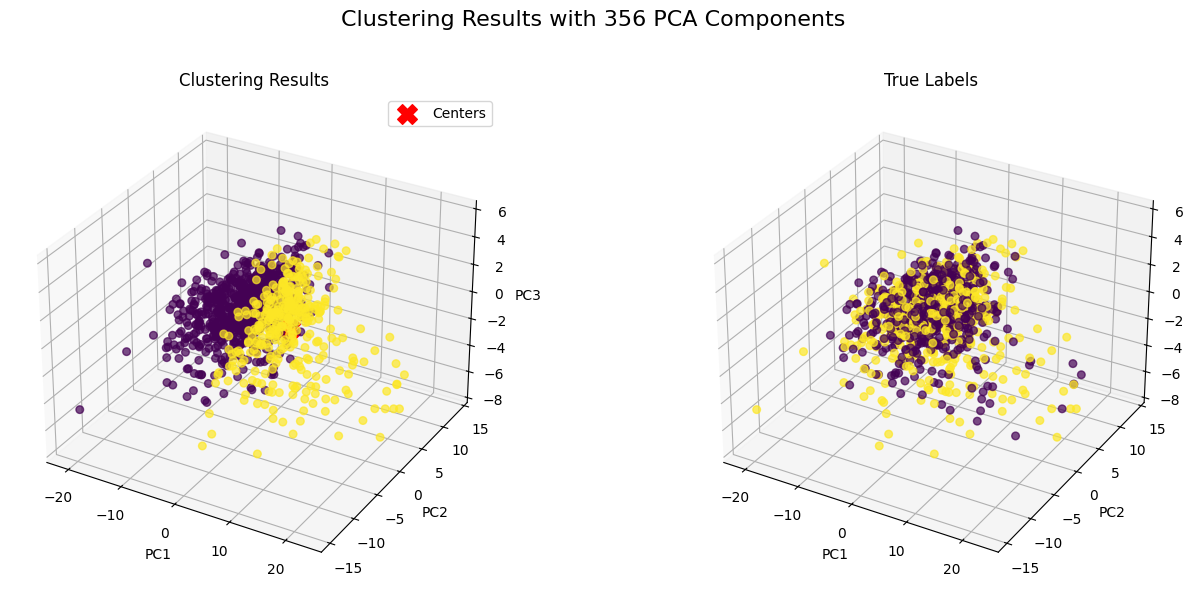

In [81]:
results = clustering_pipeline(
    X, 
    y=y_numeric,
    n_clusters=2, 
    variance_threshold_quantile=0.03,   
    correlation_threshold=0.85,         
    pca_variance_explained_threshold=0.95,  
    kmeans_max_iters=300,               
    kmeans_tol=1e-8,                    
    kmeans_n_init=25,                   
    kmeans_random_state=42              
)